In [4]:
import sys

from langchain.utilities import SQLDatabase
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import json


In [5]:
def load_data_json(DATASET):
    # Open the JSON file and load data
    with open(DATASET, 'r') as json_file:
        return json.load(json_file)

def calculateAccuracy(DATASET1):
    df = pd.DataFrame(DATASET1)
    success = df[df['predict_success']==True]
    return len(success)/len(df)*100


import ast
from langchain.utilities import SQLDatabase


def string_to_array(input):
    return ast.literal_eval(input)

def correctCase(llm_table_list, db_SQLDatabase):
    corrected_tables = []
    db_table_list = db_SQLDatabase.get_usable_table_names()
    for table_name in llm_table_list:
        for table in db_table_list:
            if table_name.casefold() == table.casefold():
                corrected_tables.append(table)
    return corrected_tables

# Modificar esto eventualmente por una tecnica de RAG
def getSQLDatabase(db_id):
    # Modificar el PATH para donde este la base de datos
    db_path = '/Users/joaquinoldan/Documents/MASTER_AI/4-Tesis/spider/database/'
    uri = 'sqlite:///' + db_path + db_id + '/' + db_id + '.sqlite'
    db = SQLDatabase.from_uri(uri,  sample_rows_in_table_info=0)
    return db


def is_table_in_query(query_gold, tables_list_filtered):
    # Split the query string by spaces
    query_words = query_gold.split(' ')

    # Find the indexes of "FROM" and "JOIN" keywords
    from_indexes = [i for i, word in enumerate(query_words) if word == "FROM"]
    join_indexes = [i for i, word in enumerate(query_words) if word == "JOIN"]
    
    in_table = True
    if from_indexes:        
        for index in from_indexes:
            table_name = query_words[index + 1].strip().strip(')').strip('(').strip(';') # word after from
            from_table_is_in_table_list = table_name.lower() in [table.lower() for table in tables_list_filtered]
            in_table = in_table and from_table_is_in_table_list
    if join_indexes:
        for index in from_indexes:
            table_name = query_words[index + 1].strip().strip(')').strip('(').strip(';')
            join_table_is_in_table_list = table_name.lower() in [table.lower() for table in tables_list_filtered]
            in_table = in_table and join_table_is_in_table_list
    return in_table


def tableFilterAccuracy(dataset):
    table_in_query = []
    for index, row in enumerate(dataset):
        query_gold = row['gold_query']
        table_filter_correct = False
        try:
            db_SQLDatabase = getSQLDatabase(row['db_id'])
            llm_table_list = string_to_array(row['table_list'])
            corrected_llm_table_list = correctCase(llm_table_list, db_SQLDatabase)
            table_filter_correct = is_table_in_query(query_gold, corrected_llm_table_list)
            row.update({'table_filter_correct':table_filter_correct})
        except Exception as e:
            row.update({'table_filter_correct':'parsing_error'})
    return None

    

In [6]:


#DATASET0 = load_data_json('/Users/joaquinoldan/Documents/MASTER_AI/4-Tesis/A-Github/lalossSQL/SQL_GPU/results/DIN_SQL_Mixtral-500-results.json')

DATASET1 = load_data_json('/Users/joaquinoldan/Documents/MASTER_AI/4-Tesis/A-Github/lalossSQL/SQL_GPU/results/all-tables-pred-sqlcoder2-final-results.json')
DATASET2 = load_data_json('/Users/joaquinoldan/Documents/MASTER_AI/4-Tesis/A-Github/lalossSQL/SQL_GPU/results/all-tables-pred-mixtral-sqlcoder2-final-results-2.json')
DATASET3 = load_data_json('/Users/joaquinoldan/Documents/MASTER_AI/4-Tesis/A-Github/lalossSQL/SQL_GPU/results/all-tables-pred-sqlcoder-7b-2-final-results.json')
DATASET4 = load_data_json('/Users/joaquinoldan/Documents/MASTER_AI/4-Tesis/A-Github/lalossSQL/SQL_GPU/results/all-tables-pred-mixtral-sqlcoder-7b-2-final-results.json')
DATASET5 = load_data_json('/Users/joaquinoldan/Documents/MASTER_AI/4-Tesis/A-Github/lalossSQL/SQL_GPU/results/gpt/pred-da-vinci-sqlcoder-7b-results.json')
DATASET6 = load_data_json('/Users/joaquinoldan/Documents/MASTER_AI/4-Tesis/A-Github/lalossSQL/SQL_GPU/results/gpt/pred-gpt3.5-sqlcoder-7b-results.json')
DATASET7 = load_data_json('/Users/joaquinoldan/Documents/MASTER_AI/4-Tesis/A-Github/lalossSQL/SQL_GPU/results/gpt/tables-gpt4-sqlcoder-7b-results-2.json')

DATASETS = [DATASET1, DATASET2, DATASET3, DATASET4, DATASET5, DATASET6, DATASET7]


for DATASET in DATASETS:
    tableFilterAccuracy(DATASET)

df_datasets = [pd.DataFrame(DATASET) for DATASET in DATASETS]



In [7]:
accuracies = []
for df in df_datasets:
    accuracy = calculateAccuracy(df)
    accuracies.append(accuracy)

/var/folders/gx/jg0hqjbs64jc96qwrctpn5wc0000gn/T/ipykernel_74924/2453617686.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Models', y='Accuracy', data=df, palette=palette, ax=ax)


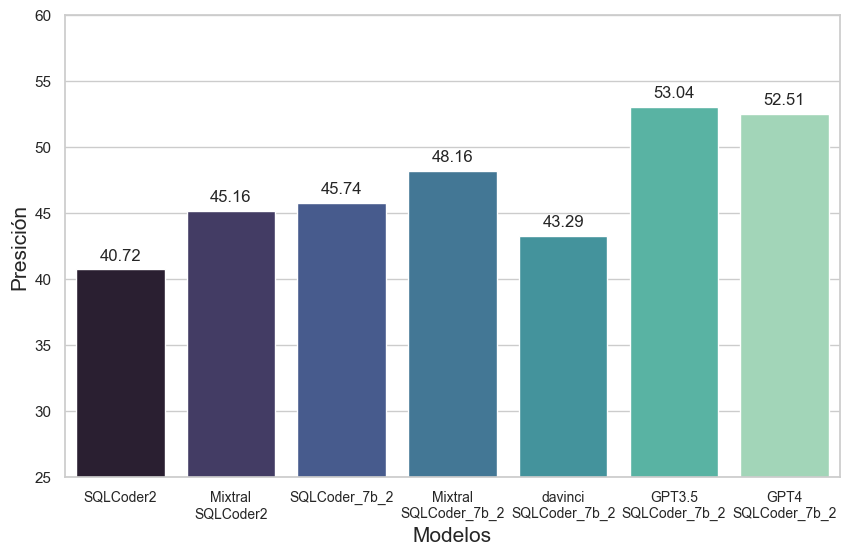

In [12]:
# Sample data (replace this with your actual data)
models = ['SQLCoder2', 'Mixtral\nSQLCoder2', 'SQLCoder_7b_2', 'Mixtral\nSQLCoder_7b_2',  'davinci\nSQLCoder_7b_2','GPT3.5\nSQLCoder_7b_2','GPT4\nSQLCoder_7b_2']

# Create a DataFrame from the data
data = {'Models': models, 'Accuracy': accuracies}
df = pd.DataFrame(data)

# Set the style for better aesthetics (optional)
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Create the bar plot with Seaborn
palette = sns.color_palette("mako", len(models))
sns.barplot(x='Models', y='Accuracy', data=df, palette=palette, ax=ax)

# Add labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Customize the plot
ax.set_xlabel('Modelos', fontsize=15)
ax.set_ylabel('Presición', fontsize=15)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylim(25, 60)  # Set the y-axis limit between 0 and 1 for accuracy values

# Show the plot
plt.show()


/var/folders/gx/jg0hqjbs64jc96qwrctpn5wc0000gn/T/ipykernel_74924/1216617585.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Dataset', y='True Percentage', data=df_true_percentage, palette=palette)


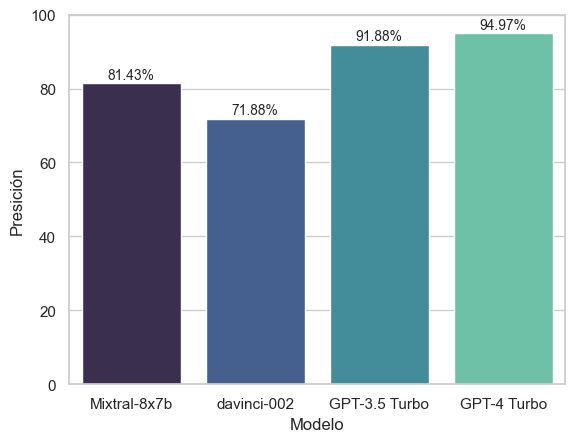

In [13]:
davinci = df_datasets[4]
GPT3 = df_datasets[5]
GPT4 = df_datasets[6]
mixtral = df_datasets[3]


# Calculate percentage of True values in 'table_filter_correct' column for each DataFrame
mixtral_true_percentage = (mixtral['table_filter_correct'].value_counts()[True]  / len(mixtral)) * 100
davinci_true_percentage = (davinci['table_filter_correct'].value_counts()[True]  / len(davinci)) * 100
gpt3_true_percentage = (GPT3['table_filter_correct'].value_counts()[True] / len(GPT3)) * 100
gpt4_true_percentage = (GPT4['table_filter_correct'].value_counts()[True]  / len(GPT4)) * 100

# Create a DataFrame for plotting
df_true_percentage = pd.DataFrame({
    'Dataset': ['Mixtral-8x7b', 'davinci-002', 'GPT-3.5 Turbo', 'GPT-4 Turbo'],
    'True Percentage': [mixtral_true_percentage,davinci_true_percentage, gpt3_true_percentage, gpt4_true_percentage]
})

# Set the style for better aesthetics (optional)
sns.set(style="whitegrid")

# Choose a color palette
palette = sns.color_palette("mako", 4)

# Create the bar plot with Seaborn
ax = sns.barplot(x='Dataset', y='True Percentage', data=df_true_percentage, palette=palette)

# Add percentage labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=10)

ax.set_ylim(0, 100) 
# Customize the plot
ax.set(xlabel='Modelo', ylabel='Presición')

# Show the plot

plt.show()
